Thanh Truc Bui

In [3]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import h5py
import os
from dotenv import load_dotenv
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import f1_score, matthews_corrcoef,accuracy_score


In [4]:
load_dotenv() # load environment variables

path_to_csv_split30=os.getenv("CSV30_ENZYMES","not found")

Load data to make a dataframe

In [5]:
df_raw=pd.read_csv(path_to_csv_split30, delimiter=",") # Multiclass enzymes are in this df
df= df_raw[df_raw["EC number"].str.contains(";") == False]  #Remove multiclass enzymes
df=df.reset_index(drop=True)
df


,Entry,EC number,Sequence
0,O88483,3.1.3.43,MPAPTQLFFPLVRNCELSRIYGTACYCHHKHLCCSPPYIPQNRLRY...
1,O53896,3.4.21.107,MAKLARVVGLVQEEQPSDMTNHPRYSPPPQQPGTPGYAQGQQQTYS...
2,Q9QYJ6,3.1.4.17,MEDGPSNNASCFRRLTECFLSPSLTDEKVKAYLSLHPQVLDEFVSE...
3,Q63421,3.1.4.35,MTDTSHKKEGFKKCRSATFSIDGYSFTIVANEAGDKNARPLARFSR...
4,B0G0Y8,3.1.4.35,MAPQQNIMKQLQQMQSSPYPSSSPSSTTVSQNNDNLNHNVHSLNNS...
...,...,...,...
8565,A1L4V7,4.4.1.15,MKVQRSTFLAVTGKSNLHHFHSSSQRIPITSEIDSREFVSKLLDRK...
8566,Q1HRV8,2.3.1.199,MALIMKYIDSMHHYMDKYGDPRTKDWPLMSSPFPTLALCLGYVYLV...
8567,Q94F30,3.4.22.68,MGAVAINRKRSDESFNFINQQSTNPLRNSPYFQASKKRRFSFAMSE...
8568,I6XU97,3.1.1.1,MLSDDELTGLDEFALLAENAEQAGVNGPLPEVERVQAGAISALRWG...


In [6]:
df['EC class'] = df['EC number'].str[:1].astype(int)
clist = list(df.columns)
clist_new = clist[-1:]+clist[:-1]   # brings the last column in the first place
df=df[clist_new]
df.to_csv("/home/trucbui/PBLGit/rnn_prott5/dataframe")

In [7]:
df

,EC class,Entry,EC number,Sequence
0,3,O88483,3.1.3.43,MPAPTQLFFPLVRNCELSRIYGTACYCHHKHLCCSPPYIPQNRLRY...
1,3,O53896,3.4.21.107,MAKLARVVGLVQEEQPSDMTNHPRYSPPPQQPGTPGYAQGQQQTYS...
2,3,Q9QYJ6,3.1.4.17,MEDGPSNNASCFRRLTECFLSPSLTDEKVKAYLSLHPQVLDEFVSE...
3,3,Q63421,3.1.4.35,MTDTSHKKEGFKKCRSATFSIDGYSFTIVANEAGDKNARPLARFSR...
4,3,B0G0Y8,3.1.4.35,MAPQQNIMKQLQQMQSSPYPSSSPSSTTVSQNNDNLNHNVHSLNNS...
...,...,...,...,...
8565,4,A1L4V7,4.4.1.15,MKVQRSTFLAVTGKSNLHHFHSSSQRIPITSEIDSREFVSKLLDRK...
8566,2,Q1HRV8,2.3.1.199,MALIMKYIDSMHHYMDKYGDPRTKDWPLMSSPFPTLALCLGYVYLV...
8567,3,Q94F30,3.4.22.68,MGAVAINRKRSDESFNFINQQSTNPLRNSPYFQASKKRRFSFAMSE...
8568,3,I6XU97,3.1.1.1,MLSDDELTGLDEFALLAENAEQAGVNGPLPEVERVQAGAISALRWG...


Create an enzyme class to asssign atributes to the enzymes

In [8]:
class Enzyme:
    def __init__(self, header, ec_class, ec_number, seq):
        self.header=header
        self.ec_class=ec_class
        self.ec_number=ec_number
        self.seq=seq
        self.embeddings=None
        


In [9]:
def readcsv(path_to_csv:str) -> dict():
    enzymes_map=dict()
    with open(path_to_csv, "r") as path:
        line=path.readline()
        for line in path.readlines():
            field = line.strip().split(",")
            header=field[2]
            ec_class=field[1]
            ec_number=field[3]
            seq=field[4]
            enzymes_map[header]=Enzyme(header,ec_class,ec_number,seq)
    return enzymes_map

enzymes_map=readcsv("/home/trucbui/PBLGit/rnn_prott5/dataframe")

Adding prott5 to the df

In [10]:
def read_prott5(path_to_prott5:str,seq_map:dict) -> dict: 
    enzymes=seq_map
    with h5py.File(path_to_prott5) as hdf_handle:
        for header, emb in hdf_handle.items():
            if header in seq_map.keys():
                enzymes[header].embeddings = np.array(list(emb))
    return enzymes

path_to_prott5_split30=os.getenv("PROTT5_ENZYMES_SPLIT_30","not found") 
enzymes_map = read_prott5(path_to_prott5_split30,enzymes_map)


In [9]:
print(enzymes_map['O88483'].embeddings[0])

[ 0.03867   0.0673    0.0264   ...  0.0157    0.001873 -0.01573 ]


In [11]:
def making_df(seq_map:dict)-> pd.DataFrame(): 
    headers=[]
    classes=[]
    embs=[]
    
    for header in seq_map:
        headers.append(header)
        entry=seq_map[header]
        embs.append(entry.embeddings[0])
        classes.append(entry.ec_class)
       
    return pd.DataFrame(data={'EC class':classes ,'Entry':headers,'Embeddings':embs})

enzymes_df_with_prott5=making_df(enzymes_map)
enzymes_df_with_prott5=enzymes_df_with_prott5.sort_values(['Entry'],ascending=[True])
enzymes_df_with_prott5=enzymes_df_with_prott5.reset_index(drop=True)


In [12]:
enzymes_df_with_prott5

,EC class,Entry,Embeddings
0,3,A0A024RBG1,"[0.05814, -0.003416, 0.01239, 0.005314, -0.004..."
1,1,A0A024SMV2,"[0.03195, 0.02757, 0.0469, 0.000661, -0.01875,..."
2,3,A0A060S684,"[0.04544, 0.0222, 0.01518, 0.014725, -0.012856..."
3,3,A0A075TXZ3,"[0.0442, 0.00945, 0.03165, 0.0016575, -0.00481..."
4,2,A0A077K8G3,"[0.0233, -0.00269, -0.02176, 0.03482, 0.01855,..."
...,...,...,...
8565,4,W3XEE6,"[0.01987, 0.0004537, 0.009735, 0.01274, 0.0060..."
8566,3,W5EP13,"[0.04694, 0.012314, -0.00533, 0.0238, 0.04193,..."
8567,3,W7K139,"[0.02875, 0.03705, -0.004395, 0.0199, 0.0257, ..."
8568,3,W8QRE4,"[0.01111, 0.01811, 0.01747, 0.02338, 0.02031, ..."


Some analyses

1136 3478 2476 563 383 347 187


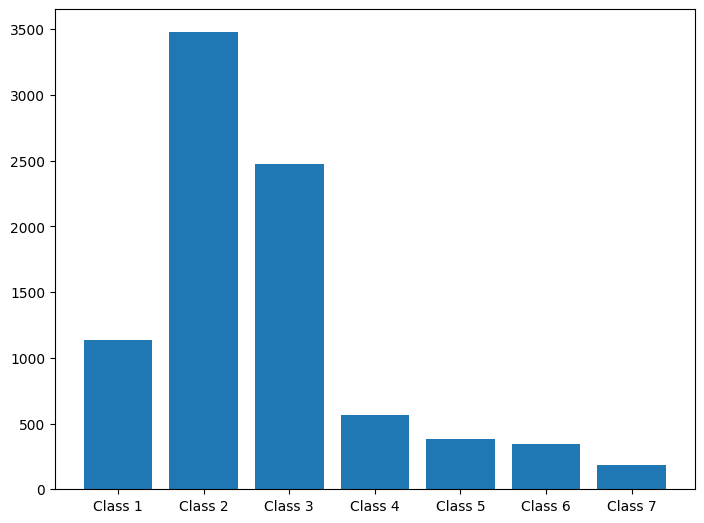

In [12]:
df1 = len(df[df["EC class"]==1])
df2 = len(df[df["EC class"]==2])
df3 = len(df[df["EC class"]==3])
df4 = len(df[df["EC class"]==4])
df5 = len(df[df["EC class"]==5])
df6 = len(df[df["EC class"]==6])
df7 = len(df[df["EC class"]==7])
print (df1, df2, df3, df4, df5, df6, df7)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
classes = ['Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5', 'Class 6', 'Class 7']
classes_values = [df1,df2,df3,df4,df5,df6,df7]
ax.bar(classes,classes_values)
plt.show()

Build a RNN model

In [22]:
class RNNModel(nn.Module):
    
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNNModel, self).__init__()
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, :])  # Use the output from the final time step
        return out
    
# Define hyperparameters
input_size = 1024 # The size of embeddings
hidden_size = 256
num_layers = 2
num_classes = 7 #the number of predicted classes

model = RNNModel(input_size, hidden_size, num_layers, num_classes)

# Define loss function and optimizer
learning_rate = 0.001
num_epochs = 10
batch_size = 32

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Transform the 1-7 class to 0-6 labels

In [16]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
enzymes_df_with_prott5['EC class encoded'] = label_encoder.fit_transform(enzymes_df_with_prott5['EC class'])



In [17]:
# Split the data into features (X) and labels (y)
y = np.array(enzymes_df_with_prott5['EC class encoded'])
X = np.array(enzymes_df_with_prott5['Embeddings'])
X = np.vstack(X).astype(np.float32)
y = np.vstack(y).astype(np.int64)

#X = torch.from_numpy(X)

# train test split. Size of train data is 80% and size of test data is 20%. 
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state = 42) 



In [18]:

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

In [19]:
X_train_tensor


tensor([[ 0.0435,  0.1057,  0.0122,  ...,  0.0039, -0.0519, -0.0282],
        [ 0.0271, -0.0149, -0.0349,  ...,  0.0123, -0.0146,  0.0253],
        [ 0.0328, -0.0480,  0.0346,  ..., -0.0544,  0.0361,  0.0473],
        ...,
        [ 0.0564, -0.0632,  0.0193,  ...,  0.0059,  0.0179,  0.0263],
        [ 0.0120,  0.0809,  0.0337,  ...,  0.0685,  0.0002,  0.0265],
        [ 0.0223,  0.0258,  0.0373,  ..., -0.0064,  0.0190, -0.0273]])

In [20]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [23]:
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    total_loss = 0.0

    for inputs, labels in train_loader:
        labels = labels.squeeze()  # Remove the extra dimension
        
        optimizer.zero_grad()  # Zero the gradient buffers

        # Forward pass
        outputs = model(inputs)

        # Compute the loss
        loss = criterion(outputs, labels)

        # Backpropagation
        loss.backward()

        # Update the weights
        optimizer.step()

        total_loss += loss.item()

    # Calculate and print the average loss for the epoch
    avg_loss = total_loss / len(train_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Avg. Loss: {avg_loss:.4f}')

Epoch [1/10], Avg. Loss: 1.4716
Epoch [2/10], Avg. Loss: 0.9746
Epoch [3/10], Avg. Loss: 0.7734
Epoch [4/10], Avg. Loss: 0.6711
Epoch [5/10], Avg. Loss: 0.5922
Epoch [6/10], Avg. Loss: 0.5335
Epoch [7/10], Avg. Loss: 0.4824
Epoch [8/10], Avg. Loss: 0.4325
Epoch [9/10], Avg. Loss: 0.3961
Epoch [10/10], Avg. Loss: 0.3673


Evaluate the model

In [24]:
model.eval()  # Set the model to evaluation mode
true_labels = []  # Store the true labels
predicted_labels = []  # Store the predicted labels

with torch.no_grad():  # Disable gradient computation for evaluation
    for inputs, labels in test_loader:  # Assuming you have a DataLoader for test data
        # Forward pass
        outputs = model(inputs)
        
        # Get the predicted class for each sample
        _, predicted = torch.max(outputs, 1)

        # Convert labels and predictions to numpy arrays
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels, average='weighted')
mcc = matthews_corrcoef(true_labels, predicted_labels)

print(f'Accuracy: {accuracy * 100:.2f}%')
print(f'F1 Score: {f1:.2f}')
print(f'Matthews Correlation Coefficient (MCC): {mcc:.2f}')


Accuracy: 81.16%
F1 Score: 0.81
Matthews Correlation Coefficient (MCC): 0.74
